In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F  
import urllib.request
import os
import numpy as np
import tarfile
import shutil
import glob
from torch.utils.data import Dataset, DataLoader
import cv2 as cv
import matplotlib.pyplot as plt
import torchvision.models as models
%matplotlib inline

In [ ]:
from tqdm import tqdm

from google.colab import drive

if torch.cuda.is_available():
  device=torch.device('cuda:0')
  print('Cuda')
else:
  device=torch.device('cpu')
  print('cpu')


Cuda


In [ ]:

url='http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar'
path='VOC'

In [ ]:
def get_archive(path,url):
  try:
    os.mkdir(path)
  except:
    path=path
  
  filename='devkit'
  urllib.request.urlretrieve(url,f"{path}/{filename}.tar")
 
get_archive(path,url)


In [ ]:
def extract(path):
  tar_file=tarfile.open(f"{path}/devkit.tar")
  tar_file.extractall('./')
  tar_file.close()
  shutil.rmtree(path)

extract(path)

In [ ]:
VOC_COLORMAP = [
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
]

In [ ]:
class VocDataset(Dataset):
  def __init__(self,dir,color_map):
    self.root=os.path.join(dir,'VOCdevkit/VOC2012')
    self.target_dir=os.path.join(self.root,'SegmentationClass')
    self.images_dir=os.path.join(self.root,'JPEGImages')
    file_list=os.path.join(self.root,'ImageSets/Segmentation/trainval.txt')
    self.files = [line.rstrip() for line in tuple(open(file_list, "r"))]
    self.color_map=color_map
    # self.pallete=self.get_collors()


  def convert_to_segmentation_mask(self,mask):
  # This function converts color channels of semgentation masks to number of classes (21 in this case)
  # Semantic Segmentation requires a segmentation mask to be a NumPy array with the shape [height, width, num_classes].
  # Each channel in this mask should encode values for a single class. Pixel in a mask channel should have
  # a value of 1.0 if the pixel of the image belongs to this class and 0.0 otherwise.
    height, width = mask.shape[:2]
    segmentation_mask = np.zeros((height, width, len(self.color_map)), dtype=np.float32)
    for label_index, label in enumerate(self.color_map):
          segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
    return segmentation_mask

  def __getitem__(self,index):
    image_id=self.files[index]
    image_path=os.path.join(self.images_dir,f"{image_id}.jpg")
    label_path=os.path.join(self.target_dir,f"{image_id}.png")
    image=cv.imread(image_path)
    image=cv.cvtColor(image,cv.COLOR_BGR2RGB)
    image=cv.resize(image,(256,256))
    image=torch.tensor(image).float()
    label=cv.imread(label_path)
    label=cv.cvtColor(label,cv.COLOR_BGR2RGB)
    label=cv.resize(label,(256,256))
    label = self.convert_to_segmentation_mask(label)
    label=torch.tensor(label).float()
    
    return image,label


  
  def __len__(self):
    return len(self.files)

In [ ]:
data=VocDataset('/content',VOC_COLORMAP)
# plt.imshow(data.__getitem__(50)[1]/255)
data.__len__()

2913

In [ ]:
train_set,val_set=torch.utils.data.random_split(data,[int(len(data)*0.9),round(len(data)*0.1)+1])
train_loader=DataLoader(train_set,batch_size=10,shuffle=True)
val_loader=DataLoader(val_set,batch_size=10,shuffle=False)

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models.pytorch


  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-katerzql
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-katerzql
     |████████████████████████████████| 58 kB 2.6 MB/s 
     |████████████████████████████████| 376 kB 10.6 MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.2.0-py3-none-any.whl size=88635 sha256=cbe6e1a6924f7946564f036e57c1d6c83bb4c385db7ef553f7ca3ce7f39c8a9a
  Stored in directory: /tmp/pip-ephem-wheel-cache-gatgy3dg/wheels/fa/c5/a8/1e8af6cb04a0974db8a4a156ebd2fdd1d99ad2558d3fce49d4
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-py3-none-any.whl size=12421 sha256=f38fb28e8a52da923bb5ba905b4527f219acf2b744f74813dc04ad67314a8504
  Stored in directory: /root/.cache/pip/wheels/90/6b/0c/f0ad36d00310e65390b0d4c9218ae6250ac579c92540c9097a
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-n

In [ ]:

import segmentation_models_pytorch as smp
model = smp.Unet(encoder_name='resnet18',classes=21,activation='softmax')
model=model.to(device)
criterion = smp.utils.losses.DiceLoss(eps=1.)
metrics = smp.utils.metrics.IoU(eps=1.)
optimizer=torch.optim.Adam(model.parameters(),lr=0.0001)
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=3,verbose=True)

In [ ]:
def train(model,optim,loss_f,epochs,scheduler,path_for_models):
  try:
    os.mkdir(path_for_models)
  except:
    path_for_models=path_for_models

  min_iou=0.3
  for epoch in tqdm(range(epochs)):
    for (X_train,y_train) in train_loader:
      X_train,y_train=X_train.to(device),y_train.to(device,dtype=torch.int64)
      X_train = X_train.permute(0, 3, 1, 2)
      y_train = y_train.permute(0, 3, 1, 2)
      y_pred=model(X_train)
      loss=loss_f(y_pred,y_train)

      optim.zero_grad()
      loss.backward()
      optim.step()
    ious=[]
    val_losses=[]
    with torch.no_grad():
      for b,(X_test,y_test) in enumerate(val_loader):
        X_test,y_test=X_test.to(device),y_test.to(device)
        X_test = X_test.permute(0, 3, 1, 2)
        y_test = y_test.permute(0, 3, 1, 2)
        y_val=model(X_test)
        val_loss=loss_f(y_val,y_test)
        val_losses.append(val_loss)
        iou_=metrics(y_val,y_test)
        ious.append(iou_)
      ious=torch.tensor(ious)
      val_losses=torch.tensor(val_losses)
      scheduler.step(val_losses.mean())
      if ious.mean() > min_iou:
        min_iou=ious.mean()
        torch.save(model.state_dict(),f"{path_for_models}/unetmodel.pt")
    print(f"epoch : {epoch:2} train_loss: {loss:10.4} , val_loss : {val_losses.mean()} val_iou: {ious.mean()}")


train(model,optimizer,criterion,10,scheduler,'models')

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/segmentation_models_pytorch/base/modules.py:104: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.activation(x)
 10%|█         | 1/10 [05:28<49:19, 328.85s/it]

epoch :  0 train_loss:     0.2372 , val_loss : 0.2885589301586151 val_iou: 0.6488827466964722


 20%|██        | 2/10 [10:58<43:55, 329.50s/it]

epoch :  1 train_loss:     0.6639 , val_loss : 0.26407358050346375 val_iou: 0.6479895710945129


 30%|███       | 3/10 [16:25<38:16, 328.00s/it]

epoch :  2 train_loss:     0.2863 , val_loss : 0.2526625394821167 val_iou: 0.6512693762779236


 40%|████      | 4/10 [21:50<32:42, 327.12s/it]

epoch :  3 train_loss:     0.7033 , val_loss : 0.2408788800239563 val_iou: 0.6553050875663757


 50%|█████     | 5/10 [27:16<27:13, 326.75s/it]

epoch :  4 train_loss:     0.2706 , val_loss : 0.24041648209095 val_iou: 0.6555858850479126


 60%|██████    | 6/10 [32:42<21:44, 326.21s/it]

epoch :  5 train_loss:     0.2192 , val_loss : 0.2405693382024765 val_iou: 0.6523119807243347


 70%|███████   | 7/10 [38:09<16:19, 326.48s/it]

epoch :  6 train_loss:     0.1162 , val_loss : 0.23595142364501953 val_iou: 0.6574640870094299


 80%|████████  | 8/10 [43:39<10:55, 327.81s/it]

epoch :  7 train_loss:     0.5299 , val_loss : 0.235015869140625 val_iou: 0.6567326784133911


 90%|█████████ | 9/10 [49:10<05:28, 328.77s/it]

epoch :  8 train_loss:     0.6143 , val_loss : 0.23716644942760468 val_iou: 0.6532447934150696


100%|██████████| 10/10 [54:41<00:00, 328.18s/it]

epoch :  9 train_loss:      0.193 , val_loss : 0.2352471649646759 val_iou: 0.6643279790878296


In [ ]:
model.load_state_dict(torch.load('/content/models/unetmodel.pt'))

model.eval()

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [ ]:
def decode_segmap(image,colors,nc=21):
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  # image.unsqueeze(-1)
  for l in range(0,nc):
    idx = image == l
    r[idx] = colors[l, 0]
    g[idx] = colors[l, 1]
    b[idx] = colors[l, 2]
  rgb = np.stack([r, g, b], axis=2)
  return rgb


In [ ]:
import imageio


In [ ]:
def image(img_path):
  img=cv.imread(img_path,cv.IMREAD_COLOR)
  # img=cv.resize(img,(500,))
  img=torch.tensor(img)
  image = torch.argmax(img.squeeze(), dim=2).detach().cpu().numpy()
  return image


In [ ]:
colorss =np.array([
    [0, 0, 0],
    [128, 0, 0],
    [0, 128, 0],
    [128, 128, 0],
    [0, 0, 128],
    [128, 0, 128],
    [0, 128, 128],
    [128, 128, 128],
    [64, 0, 0],
    [192, 0, 0],
    [64, 128, 0],
    [192, 128, 0],
    [64, 0, 128],
    [192, 0, 128],
    [64, 128, 128],
    [192, 128, 128],
    [0, 64, 0],
    [128, 64, 0],
    [0, 192, 0],
    [128, 192, 0],
    [0, 64, 128],
])

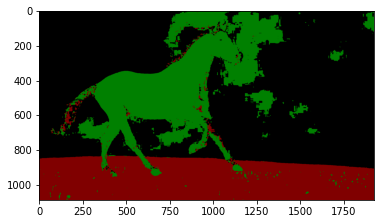

In [ ]:

rgb = decode_segmap(image('/content/hose.png'),colorss)
plt.imshow(rgb); plt.show()

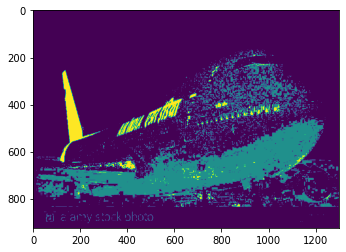

In [ ]:
plt.imshow(image('/content/aeroplane.jpg'))

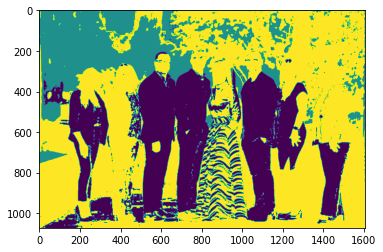

In [ ]:
plt.imshow(image('/content/people.jfif'))